# 영어-스페인어 번역기

## 데이터 전처리

In [2]:
# 한국어 글꼴 설치
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

In [3]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

In [4]:
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip',
    origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

In [5]:
with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))
print("Example:")

for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 118964
Example:
>> Go.	Ve.
>> Wait.	Esperen.
>> Hug me.	Abrázame.
>> No way!	¡Ni cagando!
>> Call me.	Llamame.


In [6]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

In [7]:
enc_corpus = []
dec_corpus = []

num_examples = 30000

for pair in raw[:num_examples]:
    eng, spa = pair.split("\t")

    enc_corpus.append(preprocess_sentence(eng))
    dec_corpus.append(preprocess_sentence(spa, s_token=True, e_token=True))

print("English:", enc_corpus[100])   # go away !
print("Spanish:", dec_corpus[100])   # <start> salga de aqu ! <end>

English: go away !
Spanish: <start> salga de aqu ! <end>


In [8]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [9]:
enc_tensor, enc_tokenizer = tokenize(enc_corpus)
dec_tensor, dec_tokenizer = tokenize(dec_corpus)

enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.2)

print("English Vocab Size:", len(enc_tokenizer.index_word))
print("Spanish Vocab Size:", len(dec_tokenizer.index_word))

English Vocab Size: 4931
Spanish Vocab Size: 8893


## 모델 설계

In [10]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [11]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()

        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)

        return out

In [12]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units, return_sequences=True, return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.dec_units)   # Attention 필수 사용!

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)
        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis = -1)
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)
        # TODO: Awesome Process
        return out, h_dec, attn

In [13]:
# 코드를 실행하세요.

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 30, 1024)
Decoder Output: (64, 8894)
Decoder Hidden State: (64, 1024)
Attention: (64, 30, 1)


## 훈련하기 (1) Optimizer & Loss
- Mask는 정답지에서 \<PAD> 토큰을 찾아내어 그 부분에 대한 Loss는 구하지 않도록 하는 역할
- equal() 함수에 정확히는 \<PAD> 토큰의 인덱스를 전달하는 것이 맞지만, 대부분의 경우는 0으로 패딩되기 때문에 편의상 0으로 전달하여 처리

In [14]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

## 훈련하기 (2) train_step 구현하기
1. Encoder에 소스 문장을 전달해 컨텍스트 벡터인 enc_out을 생성
2. Decoder에 입력으로 전달할 \<start> 토큰 문장 생성
3. t=0일 때, Decoder의 Hidden State는 Encoder의 Final State로 정의
4. \<start> 문장과 enc_out, Hidden State를 기반으로 다음 단어 (t=1)를 예측
5. 예측된 단어와 정답 간의 Loss를 구한 후, t=1의 정답 단어를 다음 입력으로 사용
6. 반복

In [15]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

- @tf.function : 훈련 외적인 텐서플로우 연산을 GPU에서 동작하게 해 훈련을 가속할 수 있도록 도와주는 데코레이터
- tf.GradientTape() : 학습하며 발생한 모든 연산을 기록하는 테이프. 모델이 각 스텝의 최종 단계에서 미분값을 구하는 데에 사용

## 훈련하기 (3) 훈련 시작하기

In [16]:
from tqdm import tqdm    # tqdm
import random

In [17]:
# Define eval_step

@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]

    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)

    batch_loss = (loss / int(tgt.shape[1]))

    return batch_loss

# Training Process

from tqdm import tqdm

EPOCHS = 1

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    test_loss = 0

    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)

        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch  1: 100%|██████████| 94/94 [00:09<00:00,  9.43it/s, Test Loss 1.0741]


## 테스트하기

In [34]:
sentence = "Can I have some coffee?"
sentence = preprocess_sentence(sentence)
sentence

'can i have some coffee ?'

In [35]:
enc_tokenizer.texts_to_sequences([sentence.split()])

[[23, 2, 27, 138, 361, 5]]

In [37]:
inputs = enc_tokenizer.texts_to_sequences([sentence.split()])

In [38]:
tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

array([[ 23,   2,  27, 138, 361,   5,   0,   0,   0]], dtype=int32)

/home/aiffel0035/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/aiffel0035/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


Input: can i have some coffee ?
Predicted translation: puedo estoy en casa ? <end> 


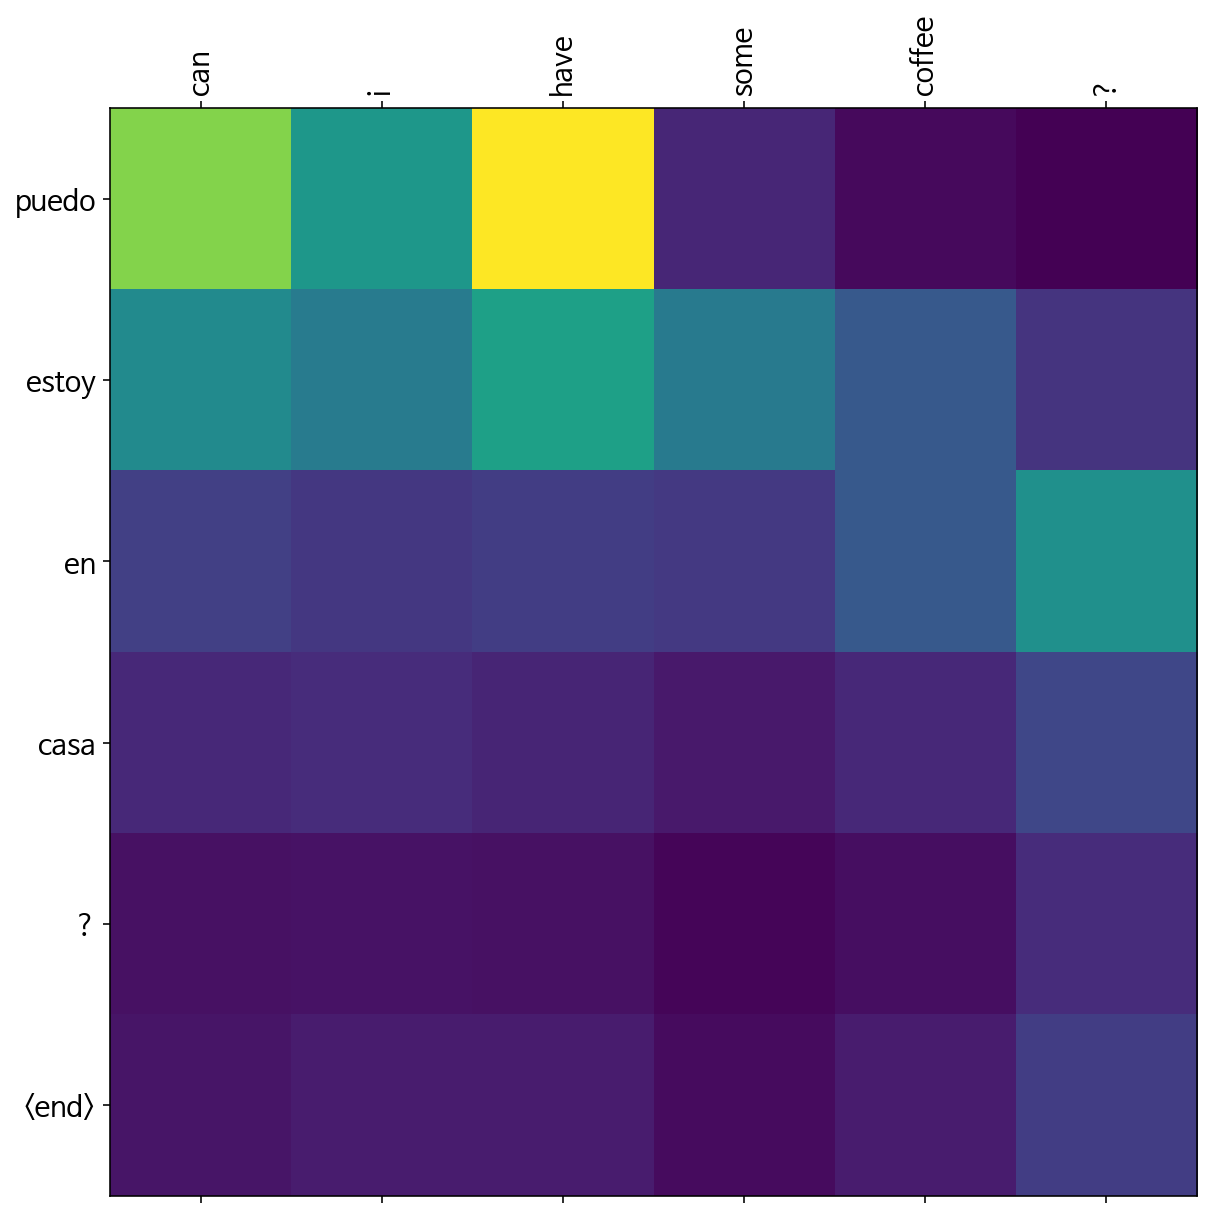

In [18]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))


translate("Can I have some coffee?", encoder, decoder)

# 한글-영어 번역기

In [19]:
import os
path = os.getenv("HOME") + "/aiffel/s2s_translation/korean-english-park."

In [20]:
ko_file = ["train.ko", "dev.ko", "test.ko"]
en_file = ["train.en", "dev.en", "test.en"]

In [21]:
enc_corpus = []
dec_corpus = []

In [22]:
for one_file in ko_file:
    with open(path+one_file, "r") as f:
        raw = f.read().splitlines()
        enc_corpus.extend(raw)

In [23]:
len(enc_corpus)

97123

In [24]:
for one_file in en_file:
    with open(path+one_file, "r") as f:
        raw = f.read().splitlines()
        dec_corpus.extend(raw)

In [25]:
len(dec_corpus)

97123

## 데이터 정제하기

In [26]:
import pandas as pd

In [27]:
df = pd.DataFrame(enc_corpus, columns=['enc'])

In [28]:
df

,enc
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?"""
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분..."
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...
...,...
97118,코리아 헤럴드는 이번 관련법 개정으로 해외 부동산을 취득하고자 하는 개인에 대한 규...
97119,또한 투자 펀드를 통해 해외 부동산에 투자하고자 하는 사람들에게도 유리해지도록 법 ...
97120,"반 외교부장관, 최근 핵 문제 관련 북한 태도에 경고"
97121,"일본, 통근 열차 탈선 사고로 최소 69명 사망"


In [29]:
df['dec'] = dec_corpus

In [30]:
df.tail()

,enc,dec
97118,코리아 헤럴드는 이번 관련법 개정으로 해외 부동산을 취득하고자 하는 개인에 대한 규...,The Korea Herald reports part of these changes...
97119,또한 투자 펀드를 통해 해외 부동산에 투자하고자 하는 사람들에게도 유리해지도록 법 ...,Other legal changes will help those aiming to ...
97120,"반 외교부장관, 최근 핵 문제 관련 북한 태도에 경고",Foreign minister Ban warned North Korea for it...
97121,"일본, 통근 열차 탈선 사고로 최소 69명 사망",Japan's derailed commuter train accident has k...
97122,중국 공안경찰은 그간 세간의 이목을 끌었던 몇몇 소송을 제기해 온 저명한 인권 운동...,Communist Chinese police have detained a promi...


In [31]:
df[df.duplicated()]

,enc,dec
7789,이들 의원 중 1명은 빌 클린턴 전 대통령이 지난 몇 주간 부인 힐러리에게 오바마의...,"One of the lawmakers said Clinton's husband, f..."
9925,*판매 제품,The goods
10070,* 알아두면 좋은 것:,Good to know:
10074,* 알아두면 좋은 것:,Good to know:
10079,* 알아두면 좋은 것:,Good to know:
...,...,...
95408,온도계가 없다면 어떻게 해야 할까?,No thermometer? Try this...
95414,온도계가 없다면 어떻게 해야 할까?,No thermometer? Try this...
95423,온도계가 없다면 어떻게 해야 할까?,No thermometer? Try this...
95428,주의를 기울어야 하는 이유,Why should you care?


In [39]:
df = df.drop_duplicates()

In [40]:
df

,enc,dec
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee..."
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...
...,...,...
97118,코리아 헤럴드는 이번 관련법 개정으로 해외 부동산을 취득하고자 하는 개인에 대한 규...,The Korea Herald reports part of these changes...
97119,또한 투자 펀드를 통해 해외 부동산에 투자하고자 하는 사람들에게도 유리해지도록 법 ...,Other legal changes will help those aiming to ...
97120,"반 외교부장관, 최근 핵 문제 관련 북한 태도에 경고",Foreign minister Ban warned North Korea for it...
97121,"일본, 통근 열차 탈선 사고로 최소 69명 사망",Japan's derailed commuter train accident has k...


In [41]:
import numpy as np
enc_corpus = list(np.array(df.enc.tolist()))
dec_corpus = list(np.array(df.dec.tolist()))

In [42]:
print(len(enc_corpus))
print(len(dec_corpus))

81959
81959


In [43]:
import re
def preprocess_sentence_kor(sentence):

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^가-힣?.!,]+", " ", sentence)

    sentence = sentence.strip()

    return sentence

In [44]:
def preprocess_sentence_eng(sentence, s_token=True, e_token=True):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

In [45]:
enc_corpus[0]

'개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"'

In [46]:
enc_cleaned = list(map(lambda x: preprocess_sentence_kor(x), enc_corpus))

In [47]:
enc_cleaned[0]

'개인용 컴퓨터 사용의 상당 부분은 이것보다 뛰어날 수 있느냐 ?'

In [48]:
dec_corpus[0]

'Much of personal computing is about "can you top this?"'

In [49]:
dec_cleaned = list(map(lambda x: preprocess_sentence_eng(x), dec_corpus))

In [50]:
dec_cleaned[0]

'<start> much of personal computing is about can you top this ? <end>'

In [51]:
from konlpy.tag import Mecab

mecab_enc_corpus = []
mecab = Mecab()
    
for sentence in enc_cleaned:
    mecab_enc_corpus.append(mecab.morphs(sentence))

In [52]:
enc_cleaned[0]

'개인용 컴퓨터 사용의 상당 부분은 이것보다 뛰어날 수 있느냐 ?'

In [53]:
mecab_enc_corpus[0]

['개인',
 '용',
 '컴퓨터',
 '사용',
 '의',
 '상당',
 '부분',
 '은',
 '이것',
 '보다',
 '뛰어날',
 '수',
 '있',
 '느냐',
 '?']

In [392]:
import tensorflow as tf
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', num_words=10000)
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, maxlen=40, padding='post')
    return tensor, tokenizer

In [393]:
enc_tensor, enc_tokenizer = tokenize(mecab_enc_corpus)

In [394]:
enc_tensor[0]

array([ 658,  602,  515,  159,    6, 1354,  849,    8,  702,  148,   40,
         13, 3382,  412,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [395]:
enc_tokenizer.sequences_to_texts([enc_tensor[0]])

['개인 용 컴퓨터 사용 의 상당 부분 은 이것 보다 수 있 느냐 ?']

In [396]:
dec_tensor, dec_tokenizer = tokenize(dec_cleaned)

In [397]:
dec_tensor[0]

array([   4,  265,    7, 1185, 7930,   16,   45,   93,   87,  202,   40,
        257,    5,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [398]:
dec_tokenizer.sequences_to_texts([dec_tensor[0]])

['<start> much of personal computing is about can you top this ? <end>']

In [399]:
print("한글 단어수:", len(enc_tokenizer.index_word))
print("영어 단어수:", len(dec_tokenizer.index_word))

한글 단어수: 43019
영어 단어수: 45348


In [400]:
enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.2)

## 모델 설계

In [406]:
# 코드를 실행하세요.

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = 10000
TGT_VOCAB_SIZE = 10000

units         = 1024
embedding_dim = 2000

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 40

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 40, 1024)
Decoder Output: (64, 10000)
Decoder Hidden State: (64, 1024)
Attention: (64, 40, 1)


In [407]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [408]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [409]:
from tqdm import tqdm    # tqdm
import random

In [410]:
# Define eval_step

@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]

    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)

    batch_loss = (loss / int(tgt.shape[1]))

    return batch_loss

# Training Process

from tqdm import tqdm

EPOCHS = 3

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    test_loss = 0

    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)

        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch  3: 100%|██████████| 257/257 [00:39<00:00,  6.44it/s, Test Loss 2.7400]


In [411]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))

In [415]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence_kor(sentence)
    inputs = mecab.morphs(sentence)
    inputs = [inputs]
    inputs = enc_tokenizer.texts_to_sequences(inputs)
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=40,
                                                           padding='post')
        
    
        
    result = ''

    enc_out = encoder(inputs)
    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()
        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()
        
        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention
        
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence, attention


Input: 오바마는 대통령이다 .
Predicted translation: obama s campaign is the first time . <end> 


/home/aiffel0035/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/home/aiffel0035/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


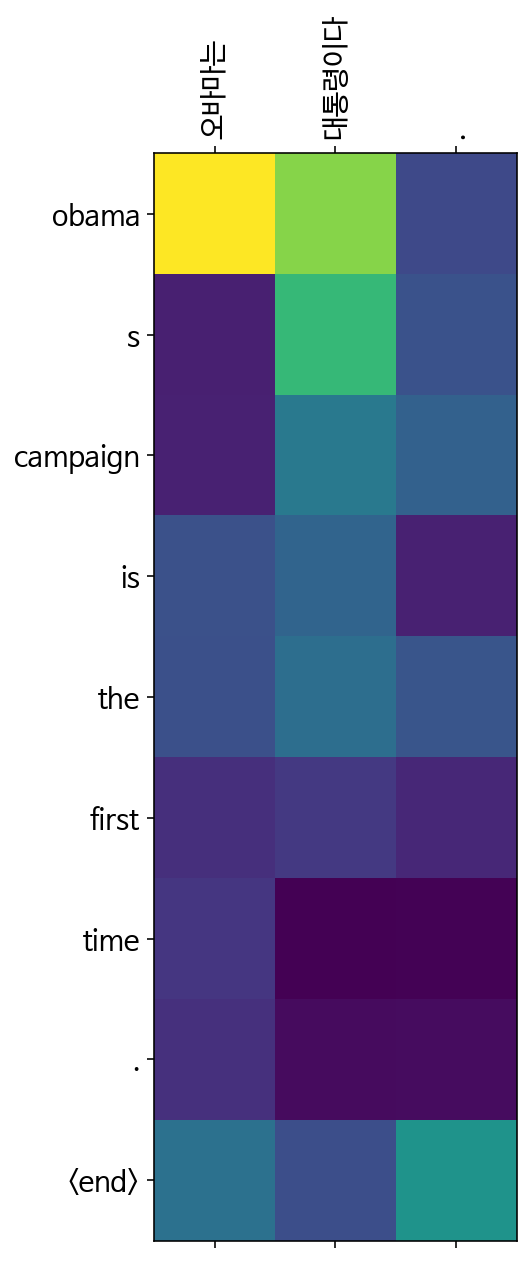

In [416]:
translate("오바마는 대통령이다.", encoder, decoder)

Input: 시민들은 도시 속에 산다 .
Predicted translation: the men were killed in the capital , the government has been killed in the capital , the government has been killed in the capital , the government has been killed in the capital , the government has been killed 


/home/aiffel0035/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/home/aiffel0035/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


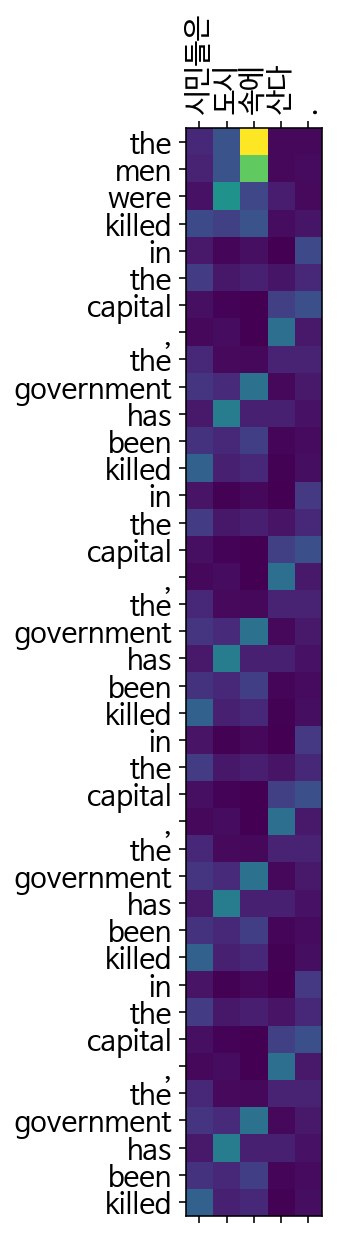

In [417]:
translate("시민들은 도시 속에 산다.", encoder, decoder)

Input: 커피는 필요 없다 .
Predicted translation: the company is a lot of the . <end> 


/home/aiffel0035/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/home/aiffel0035/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


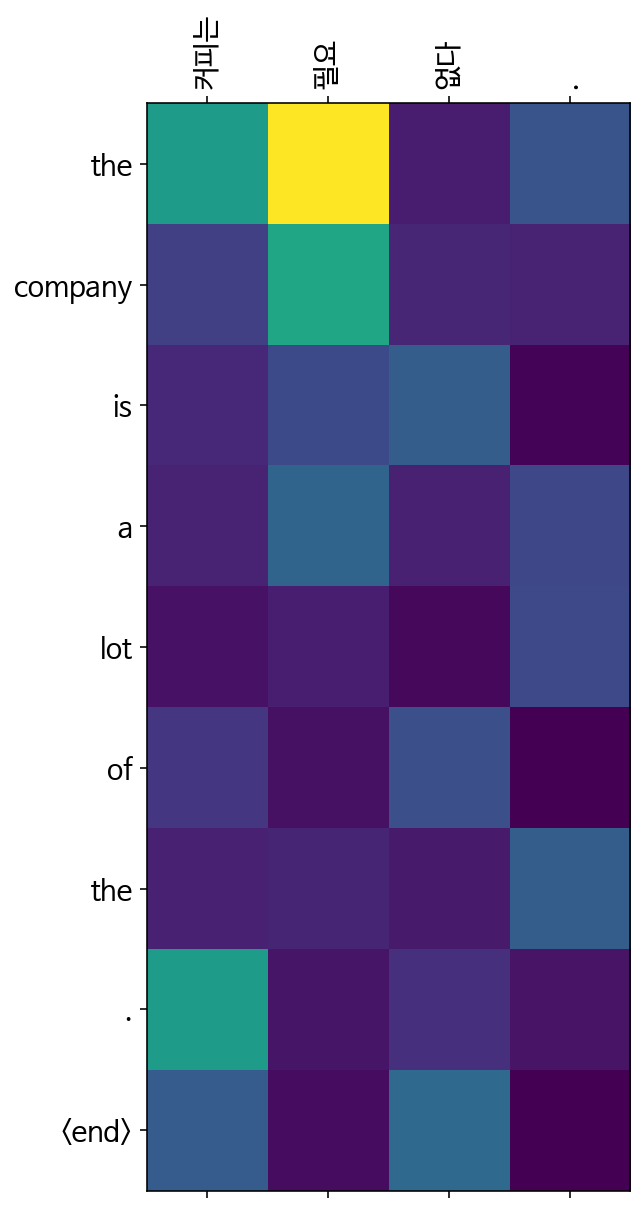

In [418]:
translate("커피는 필요 없다.", encoder, decoder)

Input: 일곱 명의 사망자가 발생했다 .
Predicted translation: the two men were killed in the capital . <end> 


/home/aiffel0035/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/home/aiffel0035/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


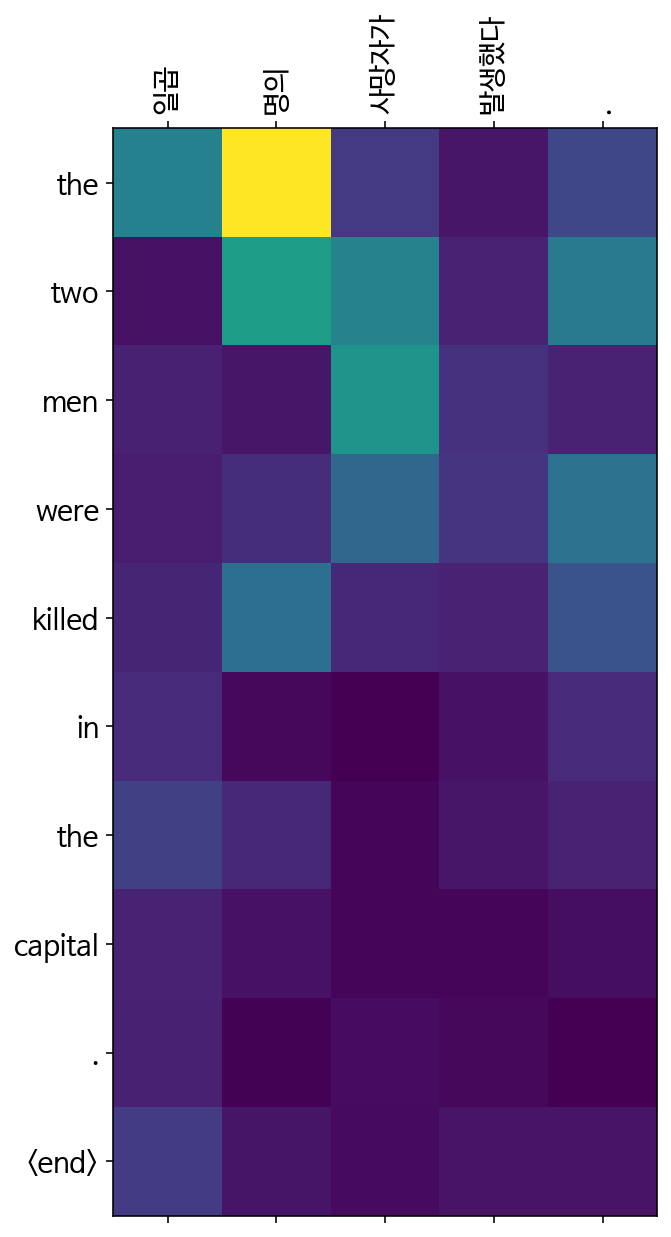

In [419]:
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)